# Project 7: Time Series Analysis


Load all the packages you are going to use.

**Data manipulation and Visualizations**

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

# to visualize the column transformer and pipeline
set_config(display='diagram')

**Modeling**

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa import stattools
import statsmodels

**Metrics**

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score, mean_squared_log_error

**Cross Validation**

In [4]:
from sklearn.model_selection import cross_validate, cross_val_score

# 1. Define project goal

In this project, I will create a short-term temperature forecast.

Steps:

1. Get and clean temperature data from www.ecad.eu .

2. Build a baseline model modelling trend and seasonality.

3. Plot and inspect the different components of a time series.

4. Model time dependence of the remainder using an AR model.

5. Compare the statistical output of different AR models.

6. Test the remainder for stationarity.

# 2. Get the data

Get ECAD Temperature Data.

Go to www.ecad.eu .

Go to “Daily data”.

Click on “Custom query (ASCII)”.

Pick:

1. Type of series: blend

2. Country: Germany

3. Location: Berlin-Tempelhof

4. Element: Mean temperature


## Load and clean the data.

**Read the file TG_STAID002759.txt into Python and print a few rows.**

In [5]:
df = pd.read_csv("TG_STAID002759.txt", index_col = 1, parse_dates = True, skiprows = 19)

In [6]:
df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [7]:
df.shape

(53630, 3)

In [8]:
df.columns

Index([' SOUID', '   TG', ' Q_TG'], dtype='object')

**Column names contain spaces. Rename the columns to avoid key errors.**

In [9]:
df.columns = ["Source_ID", "Mean_temp", "Q_mean_temp"]

In [10]:
df.columns

Index(['Source_ID', 'Mean_temp', 'Q_mean_temp'], dtype='object')

In [11]:
df.index

DatetimeIndex(['1876-01-01', '1876-01-02', '1876-01-03', '1876-01-04',
               '1876-01-05', '1876-01-06', '1876-01-07', '1876-01-08',
               '1876-01-09', '1876-01-10',
               ...
               '2022-10-22', '2022-10-23', '2022-10-24', '2022-10-25',
               '2022-10-26', '2022-10-27', '2022-10-28', '2022-10-29',
               '2022-10-30', '2022-10-31'],
              dtype='datetime64[ns]', name='    DATE', length=53630, freq=None)

**Check for missing values in the dataset.**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53630 entries, 1876-01-01 to 2022-10-31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Source_ID    53630 non-null  int64
 1   Mean_temp    53630 non-null  int64
 2   Q_mean_temp  53630 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


Seems that there are no missing values in the dataset.
But is it true???

**Data Dictionary**

EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 12-12-2022. THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:
Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu



**FILE FORMAT (MISSING VALUE CODE IS -9999):**

**01-06 SOUID:** Source identifier

**08-15 DATE:** Date YYYYMMDD

**17-21 TG:** mean temperature in 0.1 &#176;C

**23-27 Q_TG:** Quality code for TG (0='valid'; 1='suspect'; 9='missing')



This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).
Blended and updated with sources: 111448 127488 128124 
See file sources.txt and stations.txt for more info.

In [13]:
#df[df["Mean_temp"] == -9999]

In [14]:
df["Q_mean_temp"].value_counts()


0    53435
9      195
Name: Q_mean_temp, dtype: int64

In [15]:
df[df["Q_mean_temp"] == 9]

,Source_ID,Mean_temp,Q_mean_temp
DATE,,,
1945-04-25,127488,-9999,9
1945-04-26,127488,-9999,9
1945-04-27,127488,-9999,9
1945-04-28,127488,-9999,9
1945-04-29,127488,-9999,9
...,...,...,...
1945-11-01,127488,-9999,9
1945-11-02,127488,-9999,9
1945-11-03,127488,-9999,9


Replace mean temperature for the WWII's end period with the mean value of the temperatures for the previous (1944) and following (1946) year's same dates.

In [16]:
mean_val = (df["1946-04-25":"1946-11-05"]["Mean_temp"].values + df["1944-04-25":"1944-11-05"]["Mean_temp"].values)/2.0

In [17]:
idx = df["1945-04-25":"1945-11-05"].index

In [18]:
mean_45 = pd.Series(mean_val, index = idx)

In [19]:
mean_45

    DATE
1945-04-25    115.0
1945-04-26    134.0
1945-04-27    123.0
1945-04-28    111.5
1945-04-29    101.0
              ...  
1945-11-01     54.0
1945-11-02     56.0
1945-11-03     62.5
1945-11-04     71.0
1945-11-05     77.5
Length: 195, dtype: float64

In [20]:
df.loc["1945-04-25":"1945-11-05", "Mean_temp"] = mean_45

In [21]:
df[df["Q_mean_temp"] == 9]


,Source_ID,Mean_temp,Q_mean_temp
DATE,,,
1945-04-25,127488,115.0,9
1945-04-26,127488,134.0,9
1945-04-27,127488,123.0,9
1945-04-28,127488,111.5,9
1945-04-29,127488,101.0,9
...,...,...,...
1945-11-01,127488,54.0,9
1945-11-02,127488,56.0,9
1945-11-03,127488,62.5,9


**Adjust temperature unit (0.1 degrees).**

In [22]:
df["Mean_temp"] = df["Mean_temp"]/10

In [23]:
df.head(1)

,Source_ID,Mean_temp,Q_mean_temp
DATE,,,
1876-01-01,127488,2.2,0


## Create time-related features

Extract month information.

In [24]:
df["Month"] = df.index.month


Extract year information.

In [25]:
df["Year"] = df.index.year


Extract timestep information.

In [26]:
df["Timestep"] = range(len(df))

Perform One-Hot-Encoding for the month.

In [27]:
seasonal_dummies = pd.get_dummies(df.index.month, prefix = "month", drop_first = True).set_index(df.index)

In [28]:
seasonal_dummies

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-27,0,0,0,0,0,0,0,0,1,0,0
2022-10-28,0,0,0,0,0,0,0,0,1,0,0
2022-10-29,0,0,0,0,0,0,0,0,1,0,0


Join the dummies with the temp dataframe.

In [29]:
df = df.join(seasonal_dummies)

In [30]:
df.head()

,Source_ID,Mean_temp,Q_mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,,
1876-01-01,127488,2.2,0,1,1876,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,127488,2.5,0,1,1876,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,127488,0.3,0,1,1876,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,127488,-5.8,0,1,1876,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,127488,-9.8,0,1,1876,4,0,0,0,0,0,0,0,0,0,0,0


**Drop the columns which are irrelevant for the model.**

In [31]:
df.drop(["Source_ID", "Q_mean_temp"], axis = 1, inplace = True)

In [32]:
df.head(1)

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
1876-01-01,2.2,1,1876,0,0,0,0,0,0,0,0,0,0,0,0


**Check descriptive statistics and explore some basic plots.**

In [33]:
df.describe()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000,53630.000000
mean,9.438377,6.517322,1948.917192,26814.500000,0.077419,0.084971,0.082230,0.084971,0.082230,0.084971,0.084971,0.082230,0.084971,0.081671,0.084393
std,7.878243,3.446534,42.387329,15481.791805,0.267258,0.278841,0.274718,0.278841,0.274718,0.278841,0.278841,0.274718,0.278841,0.273865,0.277979
min,-22.600000,1.000000,1876.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.400000,4.000000,1912.000000,13407.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.500000,7.000000,1949.000000,26814.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.800000,10.000000,1986.000000,40221.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.500000,12.000000,2022.000000,53629.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

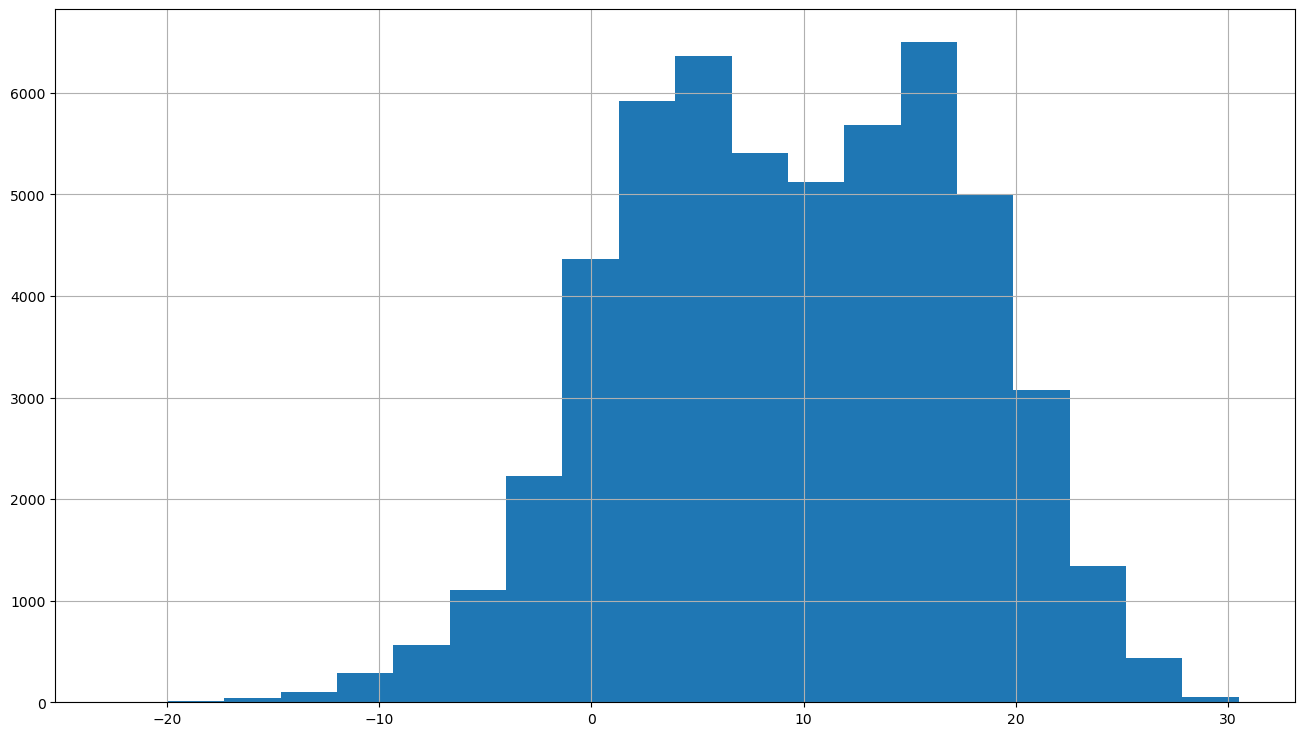

In [34]:
plt.figure(figsize=(16, 9))
df["Mean_temp"].hist(bins = 20)

Text(0, 0.5, 'Mean Temperature (in Celcius)')

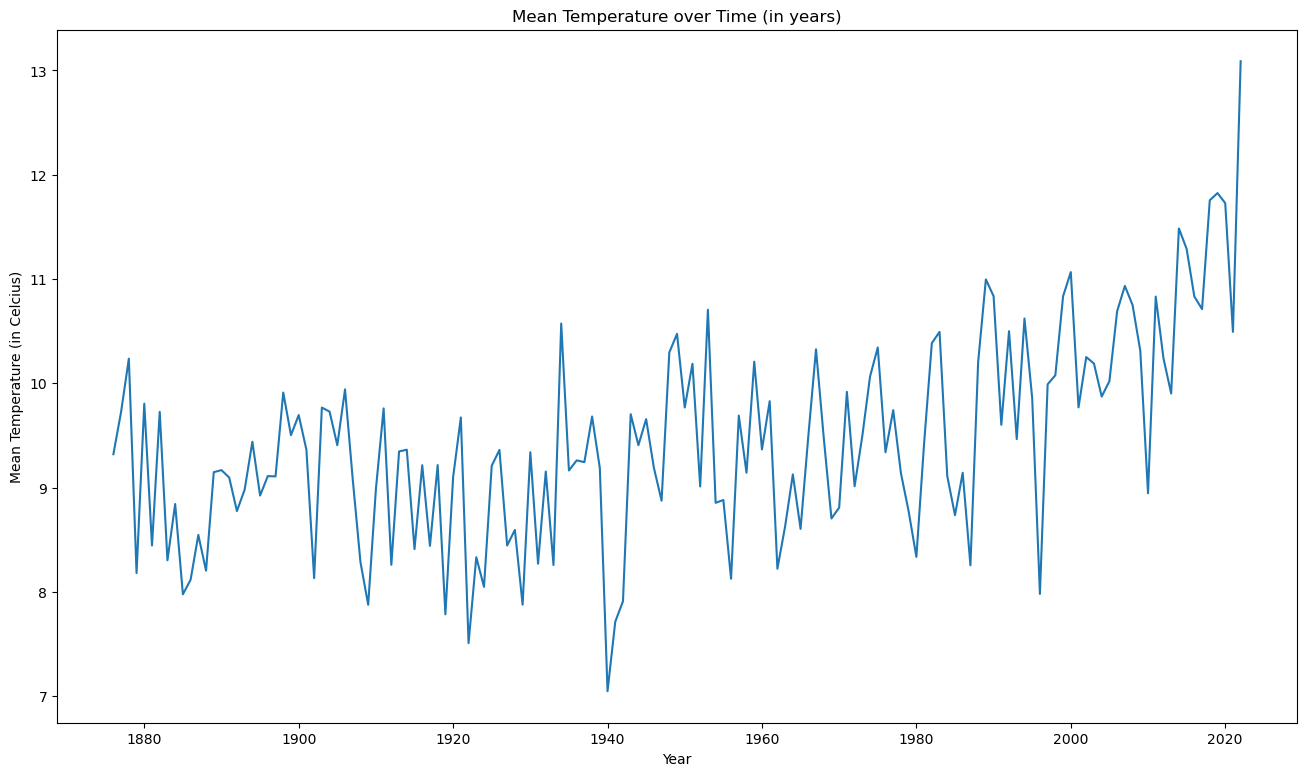

In [35]:
plt.figure(figsize=(16, 9))
df.groupby("Year")["Mean_temp"].mean().plot()
plt.title("Mean Temperature over Time (in years)")
plt.ylabel("Mean Temperature (in Celcius)")

# 3. Train-test split 

**Define train and test datasets. For the test, take the data of the last year.**

In [36]:
#df.tail()

In [37]:
df_train = df[:-365]

In [38]:
df_train.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
1876-01-01,2.2,1,1876,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,1876,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,1,1876,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,1,1876,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,1,1876,4,0,0,0,0,0,0,0,0,0,0,0


In [39]:
type(df_train)

pandas.core.frame.DataFrame

In [40]:
df_train.shape

(53265, 15)

In [41]:
df_test = df[-365:]

In [42]:
df_test.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
2021-11-01,10.4,11,2021,53265,0,0,0,0,0,0,0,0,0,1,0
2021-11-02,9.5,11,2021,53266,0,0,0,0,0,0,0,0,0,1,0
2021-11-03,7.1,11,2021,53267,0,0,0,0,0,0,0,0,0,1,0
2021-11-04,7.0,11,2021,53268,0,0,0,0,0,0,0,0,0,1,0
2021-11-05,8.3,11,2021,53269,0,0,0,0,0,0,0,0,0,1,0


In [43]:
type(df_test)

pandas.core.frame.DataFrame

In [44]:
df_test.shape

(365, 15)

# 4. Model the seasonality (trend_seasonal)

**Plot function for the trend,seasonal and the original data.**

In [45]:
def plot_temp(dataframe, title = "Mean Temperature over Time", ylim = True):
    
    '''
    
    Custom plotting function.
    
    Parameters
    ----------
    dataframe : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    
    '''
    plt.rcParams['figure.figsize'] = (14,6)
    dataframe.plot()
    plt.title(title)
    plt.ylabel("Mean Temperature (in Celcius)")
    
    if ylim:
        plt.ylim(ymin = 0)
        
    plt.show()

In [46]:
df_train.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
1876-01-01,2.2,1,1876,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,1876,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,1,1876,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,1,1876,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,1,1876,4,0,0,0,0,0,0,0,0,0,0,0


**Define X and y.**

In [47]:
X = df_train.drop(columns = ["Mean_temp", "Month", "Year"])
y = df_train["Mean_temp"]

In [48]:
X

,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,53260,0,0,0,0,0,0,0,0,1,0,0
2021-10-28,53261,0,0,0,0,0,0,0,0,1,0,0
2021-10-29,53262,0,0,0,0,0,0,0,0,1,0,0


In [49]:
m = LinearRegression()

In [50]:
m.fit(X, y)

LinearRegression()

In [51]:
df_train["Trend_seasonal"] = m.predict(X)

/tmp/ipykernel_64762/1788870784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Trend_seasonal"] = m.predict(X)


In [52]:
df_train.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Trend_seasonal
DATE,,,,,,,,,,,,,,,,
1876-01-01,2.2,1,1876,0,0,0,0,0,0,0,0,0,0,0,0,-0.874636
1876-01-02,2.5,1,1876,1,0,0,0,0,0,0,0,0,0,0,0,-0.874603
1876-01-03,0.3,1,1876,2,0,0,0,0,0,0,0,0,0,0,0,-0.874570
1876-01-04,-5.8,1,1876,3,0,0,0,0,0,0,0,0,0,0,0,-0.874538
1876-01-05,-9.8,1,1876,4,0,0,0,0,0,0,0,0,0,0,0,-0.874505


**Plot the original data vs. trend_seasonal.**

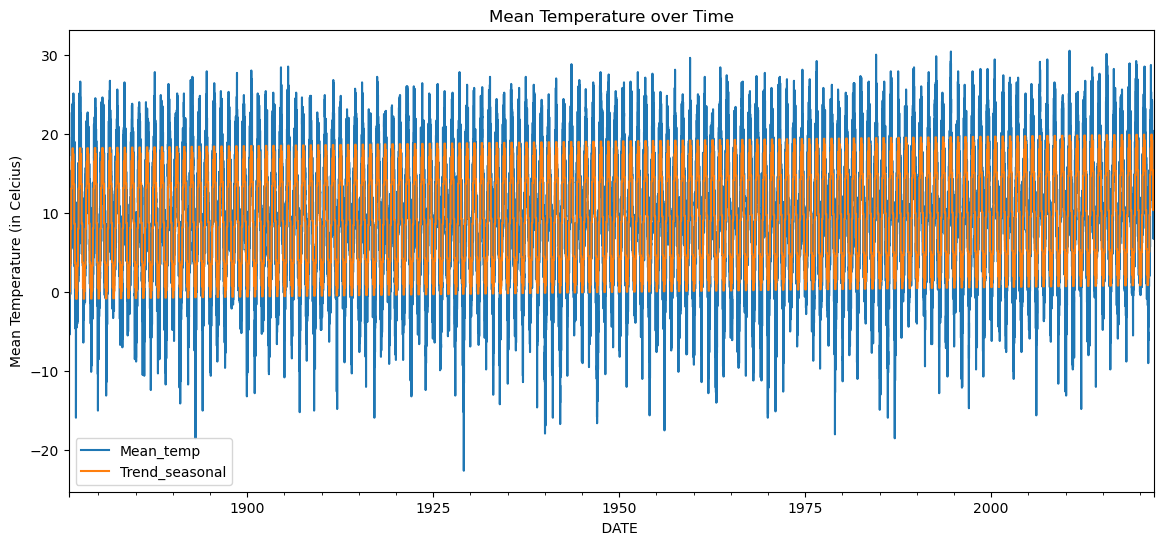

In [53]:
plot_temp(df_train[["Mean_temp", "Trend_seasonal"]], ylim = False)

# 5. Extract the remainder ł Decide on lags

## Extract remainder

In [54]:
df_train["Remainder"] = df_train["Mean_temp"] - df_train["Trend_seasonal"]

/tmp/ipykernel_64762/1063418906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Remainder"] = df_train["Mean_temp"] - df_train["Trend_seasonal"]


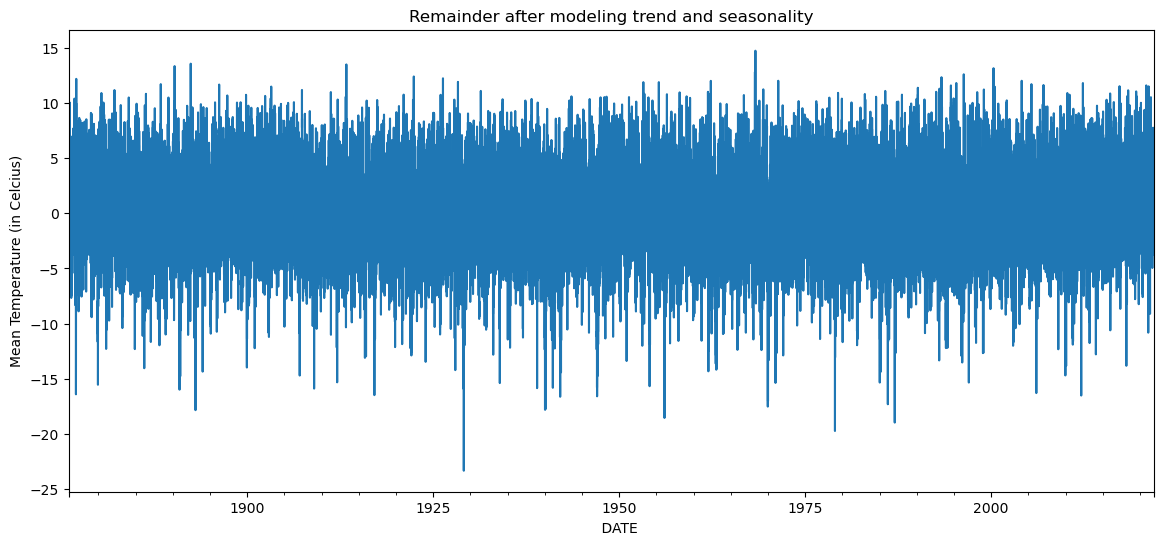

In [55]:
plot_temp(df_train["Remainder"], title = "Remainder after modeling trend and seasonality", ylim = False)

In [56]:
df_train.Remainder.mean()

4.960726177805074e-17

In [57]:
df_train["Remainder"].to_csv("temp_remainder.csv")

## Determine partial Autocorrelation

First, take a look at the different Autocorrelations.

Text(0.5, 0, 'lags')

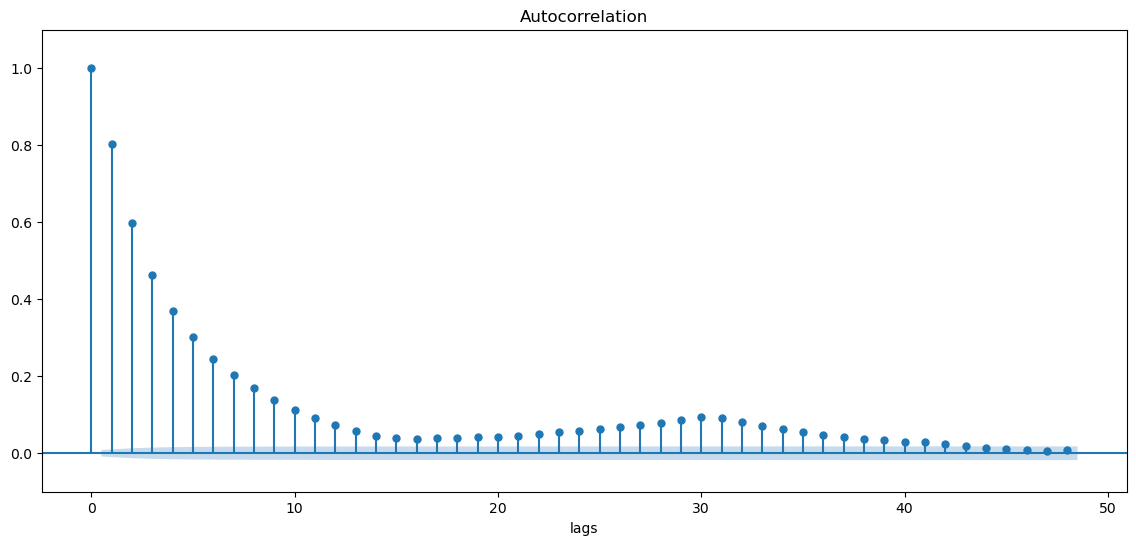

In [58]:
plt.rcParams['figure.figsize'] = (14,6)
plot_acf(df_train['Remainder'])
plt.ylim(-0.1, 1.1)
plt.xlabel('lags')

Plot partial autocorrelation function.

/home/nteni/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 0, 'lags')

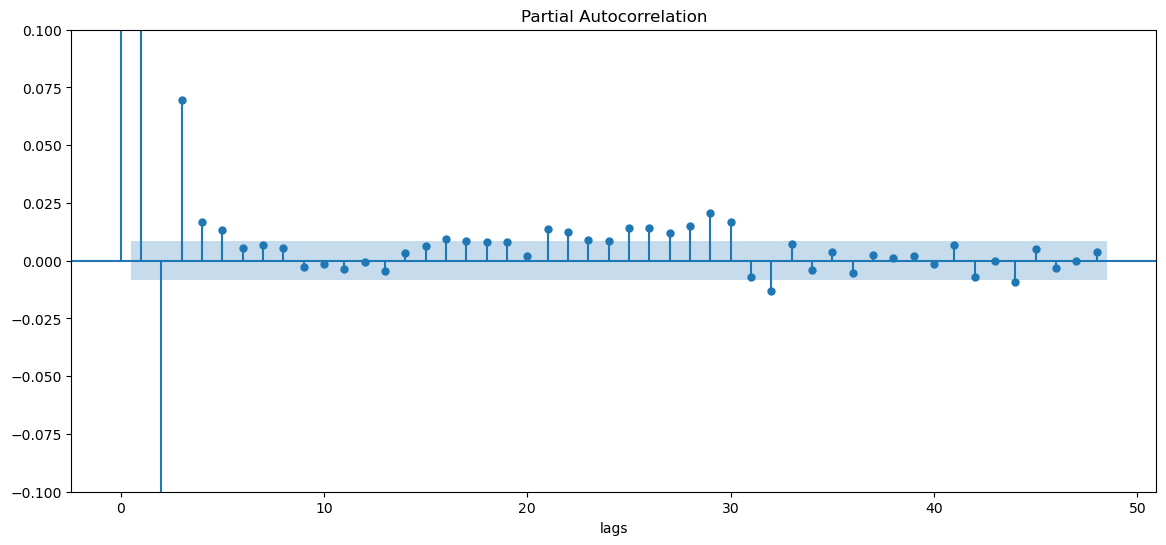

In [59]:
plt.rcParams['figure.figsize'] = (14,6)
plot_pacf(df_train['Remainder'])
plt.ylim(-0.1, 0.1)
plt.xlabel('lags')

Add 5 lags of the remainder as features to the training data.

In [60]:
df_train["lag1"] = df_train["Remainder"].shift(1)
df_train["lag2"] = df_train["Remainder"].shift(2)
df_train["lag3"] = df_train["Remainder"].shift(3)
df_train["lag4"] = df_train["Remainder"].shift(4)
df_train["lag5"] = df_train["Remainder"].shift(5)

/tmp/ipykernel_64762/2618287152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["lag1"] = df_train["Remainder"].shift(1)
/tmp/ipykernel_64762/2618287152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["lag2"] = df_train["Remainder"].shift(2)
/tmp/ipykernel_64762/2618287152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [61]:
df_train["lag1"] = df_train["lag1"].fillna(method="bfill")
df_train["lag2"] = df_train["lag2"].fillna(method="bfill")
df_train["lag3"] = df_train["lag3"].fillna(method="bfill")
df_train["lag4"] = df_train["lag4"].fillna(method="bfill")
df_train["lag5"] = df_train["lag5"].fillna(method="bfill")

/tmp/ipykernel_64762/3618155787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["lag1"] = df_train["lag1"].fillna(method="bfill")
/tmp/ipykernel_64762/3618155787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["lag2"] = df_train["lag2"].fillna(method="bfill")
/tmp/ipykernel_64762/3618155787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [62]:
df_train.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_10,month_11,month_12,Trend_seasonal,Remainder,lag1,lag2,lag3,lag4,lag5
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,1,1876,0,0,0,0,0,0,0,...,0,0,0,-0.874636,3.074636,3.074636,3.074636,3.074636,3.074636,3.074636
1876-01-02,2.5,1,1876,1,0,0,0,0,0,0,...,0,0,0,-0.874603,3.374603,3.074636,3.074636,3.074636,3.074636,3.074636
1876-01-03,0.3,1,1876,2,0,0,0,0,0,0,...,0,0,0,-0.874570,1.174570,3.374603,3.074636,3.074636,3.074636,3.074636
1876-01-04,-5.8,1,1876,3,0,0,0,0,0,0,...,0,0,0,-0.874538,-4.925462,1.174570,3.374603,3.074636,3.074636,3.074636
1876-01-05,-9.8,1,1876,4,0,0,0,0,0,0,...,0,0,0,-0.874505,-8.925495,-4.925462,1.174570,3.374603,3.074636,3.074636


In [63]:
#df_train.dropna(inplace = True)
#df_train.head()

## Run the full model

In [64]:
m_full = LinearRegression()

In [65]:
X_full = df_train.drop(columns = ["Mean_temp", "Month", "Year", "Trend_seasonal", "Remainder"])
y_full = df_train["Mean_temp"]

In [66]:
X_full.head()

,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
DATE,,,,,,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0,0,3.074636,3.074636,3.074636,3.074636,3.074636
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0,3.074636,3.074636,3.074636,3.074636,3.074636
1876-01-03,2,0,0,0,0,0,0,0,0,0,0,0,3.374603,3.074636,3.074636,3.074636,3.074636
1876-01-04,3,0,0,0,0,0,0,0,0,0,0,0,1.174570,3.374603,3.074636,3.074636,3.074636
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0,-4.925462,1.174570,3.374603,3.074636,3.074636


In [67]:
m_full.fit(X_full, y_full)

LinearRegression()

Create a new predictions column.

In [68]:
df_train["predictions_full_model"] = m_full.predict(X_full)

/tmp/ipykernel_64762/1561225135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["predictions_full_model"] = m_full.predict(X_full)


In [69]:
df_train.tail()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,Trend_seasonal,Remainder,lag1,lag2,lag3,lag4,lag5,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
2021-10-27,12.5,10,2021,53260,0,0,0,0,0,0,...,0,0,10.361438,2.138562,-0.461406,-3.661373,-2.761340,-2.761307,-2.861274,10.427600
2021-10-28,11.3,10,2021,53261,0,0,0,0,0,0,...,0,0,10.361471,0.938529,2.138562,-0.461406,-3.661373,-2.761340,-2.761307,12.145675
2021-10-29,9.2,10,2021,53262,0,0,0,0,0,0,...,0,0,10.361504,-1.161504,0.938529,2.138562,-0.461406,-3.661373,-2.761340,10.716543
2021-10-30,10.3,10,2021,53263,0,0,0,0,0,0,...,0,0,10.361537,-0.061537,-1.161504,0.938529,2.138562,-0.461406,-3.661373,9.169975
2021-10-31,13.4,10,2021,53264,0,0,0,0,0,0,...,0,0,10.361569,3.038431,-0.061537,-1.161504,0.938529,2.138562,-0.461406,10.574531


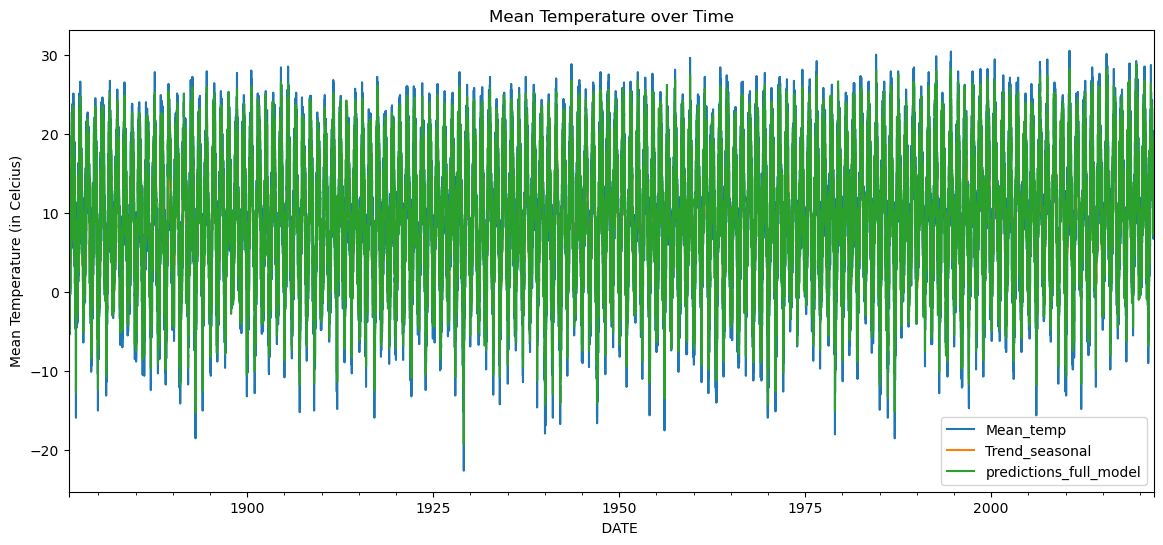

In [70]:
plot_temp(df_train[["Mean_temp", "Trend_seasonal", "predictions_full_model"]], ylim = False)

In [71]:
X_full.columns

Index(['Timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'lag2', 'lag3', 'lag4', 'lag5'],
      dtype='object')

In [72]:
m_full.coef_

array([ 3.27983640e-05,  9.60319680e-01,  4.18916884e+00,  8.82918843e+00,
        1.39101482e+01,  1.72650903e+01,  1.89904200e+01,  1.82073207e+01,
        1.44614591e+01,  9.44959729e+00,  4.56324388e+00,  1.34920202e+00,
        9.18763097e-01, -1.94032687e-01,  5.68391333e-02,  4.47114945e-03,
        1.34447885e-02])

## Augmented Dickey Fuller Test (ADF)

Null Hypothesis:The time series is non stationary.


In [73]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=0.01; CI=99%) 
            {round(levels['5%'],2)} (p=0.05; CI=95%)
            {round(levels['10%'],2)} (p=0.1 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)
   

In [74]:
print_adf(y_full)

   
            adf: -20.48
            p: 0.0 
            used lag: 58 
            number of observations: 53206
            -3.43 (p=0.01; CI=99%) 
            -2.86 (p=0.05; CI=95%)
            -2.57 (p=0.1 CI=90%) 
            information criterion (AIC): 238397.88208624368
            


I can reject the null hypothesis with a 99% confidence level, i.e. the series is stationary.

## Kwiatkowski-Phillips-Schmidt-Shin (KPSS Test)

Null hypothesis: The time series in trend stationary.

In [75]:
def print_kpss(timeseries):
    print("Results of KPSS Test:")
    kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression = "c")
    kpss_output = pd.Series(kpsstest[0:3], index = ["Test statistic", "p-value", "Lags used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical value (%s)" % key] = value
        print(kpss_output)

In [76]:
print_kpss(y_full)

Results of KPSS Test:
Test statistic            0.368396
p-value                   0.090778
Lags used               134.000000
Critical value (10%)      0.347000
dtype: float64
Test statistic            0.368396
p-value                   0.090778
Lags used               134.000000
Critical value (10%)      0.347000
Critical value (5%)       0.463000
dtype: float64
Test statistic             0.368396
p-value                    0.090778
Lags used                134.000000
Critical value (10%)       0.347000
Critical value (5%)        0.463000
Critical value (2.5%)      0.574000
dtype: float64
Test statistic             0.368396
p-value                    0.090778
Lags used                134.000000
Critical value (10%)       0.347000
Critical value (5%)        0.463000
Critical value (2.5%)      0.574000
Critical value (1%)        0.739000
dtype: float64


The null hypothesis can not be rejected, i.e. the series is stationary.

Both test conclude on stationarity.

# 6. Evaluate the model

Test via cross-validation how good the model would work on data it has not been trained on.

In [77]:
X_full.tail()

,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
DATE,,,,,,,,,,,,,,,,,
2021-10-27,53260,0,0,0,0,0,0,0,0,1,0,0,-0.461406,-3.661373,-2.761340,-2.761307,-2.861274
2021-10-28,53261,0,0,0,0,0,0,0,0,1,0,0,2.138562,-0.461406,-3.661373,-2.761340,-2.761307
2021-10-29,53262,0,0,0,0,0,0,0,0,1,0,0,0.938529,2.138562,-0.461406,-3.661373,-2.761340
2021-10-30,53263,0,0,0,0,0,0,0,0,1,0,0,-1.161504,0.938529,2.138562,-0.461406,-3.661373
2021-10-31,53264,0,0,0,0,0,0,0,0,1,0,0,-0.061537,-1.161504,0.938529,2.138562,-0.461406


First, create a TimeSeriesSplit object.

In [78]:
ts_split = TimeSeriesSplit(n_splits = 10)

Split the training data into folds.

In [79]:
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    
    print('\n')
    

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 4842 4843 4844]
The validation data for the 1th iteration are the observations steps
    [4845 4846 4847 ... 9684 9685 9686]


The training data for the 2th iteration are the observations steps 
    [   0    1    2 ... 9684 9685 9686]
The validation data for the 2th iteration are the observations steps
    [ 9687  9688  9689 ... 14526 14527 14528]


The training data for the 3th iteration are the observations steps 
    [    0     1     2 ... 14526 14527 14528]
The validation data for the 3th iteration are the observations steps
    [14529 14530 14531 ... 19368 19369 19370]


The training data for the 4th iteration are the observations steps 
    [    0     1     2 ... 19368 19369 19370]
The validation data for the 4th iteration are the observations steps
    [19371 19372 19373 ... 24210 24211 24212]


The training data for the 5th iteration are the observations steps 
    [    0     1     2 ...

Create the time series split.

In [80]:
time_series_split = ts_split.split(X_full, y_full) 

Cross-validation.

In [81]:
result = cross_val_score(estimator = m_full, 
                         X = X_full, y=  y_full,
                         cv = time_series_split)
result

array([0.91960798, 0.90672865, 0.89543796, 0.91493917, 0.91646513,
       0.91091535, 0.91443712, 0.90309206, 0.91874645, 0.92032434])

In [82]:
result.mean()

0.9120694219111577

# 7. Test the model

In [83]:
df_test.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
2021-11-01,10.4,11,2021,53265,0,0,0,0,0,0,0,0,0,1,0
2021-11-02,9.5,11,2021,53266,0,0,0,0,0,0,0,0,0,1,0
2021-11-03,7.1,11,2021,53267,0,0,0,0,0,0,0,0,0,1,0
2021-11-04,7.0,11,2021,53268,0,0,0,0,0,0,0,0,0,1,0
2021-11-05,8.3,11,2021,53269,0,0,0,0,0,0,0,0,0,1,0


In [84]:
df_test.tail()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
2022-10-27,14.7,10,2022,53625,0,0,0,0,0,0,0,0,1,0,0
2022-10-28,17.0,10,2022,53626,0,0,0,0,0,0,0,0,1,0,0
2022-10-29,16.9,10,2022,53627,0,0,0,0,0,0,0,0,1,0,0
2022-10-30,15.3,10,2022,53628,0,0,0,0,0,0,0,0,1,0,0
2022-10-31,12.9,10,2022,53629,0,0,0,0,0,0,0,0,1,0,0


Define X and y.

In [85]:
X_test = df_test.drop(columns = ["Mean_temp", "Month", "Year"])
X_test

,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
2021-11-01,53265,0,0,0,0,0,0,0,0,0,1,0
2021-11-02,53266,0,0,0,0,0,0,0,0,0,1,0
2021-11-03,53267,0,0,0,0,0,0,0,0,0,1,0
2021-11-04,53268,0,0,0,0,0,0,0,0,0,1,0
2021-11-05,53269,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-27,53625,0,0,0,0,0,0,0,0,1,0,0
2022-10-28,53626,0,0,0,0,0,0,0,0,1,0,0
2022-10-29,53627,0,0,0,0,0,0,0,0,1,0,0


In [86]:
y_test = df_test["Mean_temp"]

Predict trend and seasonality for the rest using m model from before.

In [87]:
df_test["Trend_seasonal"] = m.predict(X_test)
df_test.head()

/tmp/ipykernel_64762/4141347253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Trend_seasonal"] = m.predict(X_test)


,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Trend_seasonal
DATE,,,,,,,,,,,,,,,,
2021-11-01,10.4,11,2021,53265,0,0,0,0,0,0,0,0,0,1,0,5.441248
2021-11-02,9.5,11,2021,53266,0,0,0,0,0,0,0,0,0,1,0,5.441281
2021-11-03,7.1,11,2021,53267,0,0,0,0,0,0,0,0,0,1,0,5.441314
2021-11-04,7.0,11,2021,53268,0,0,0,0,0,0,0,0,0,1,0,5.441347
2021-11-05,8.3,11,2021,53269,0,0,0,0,0,0,0,0,0,1,0,5.441379


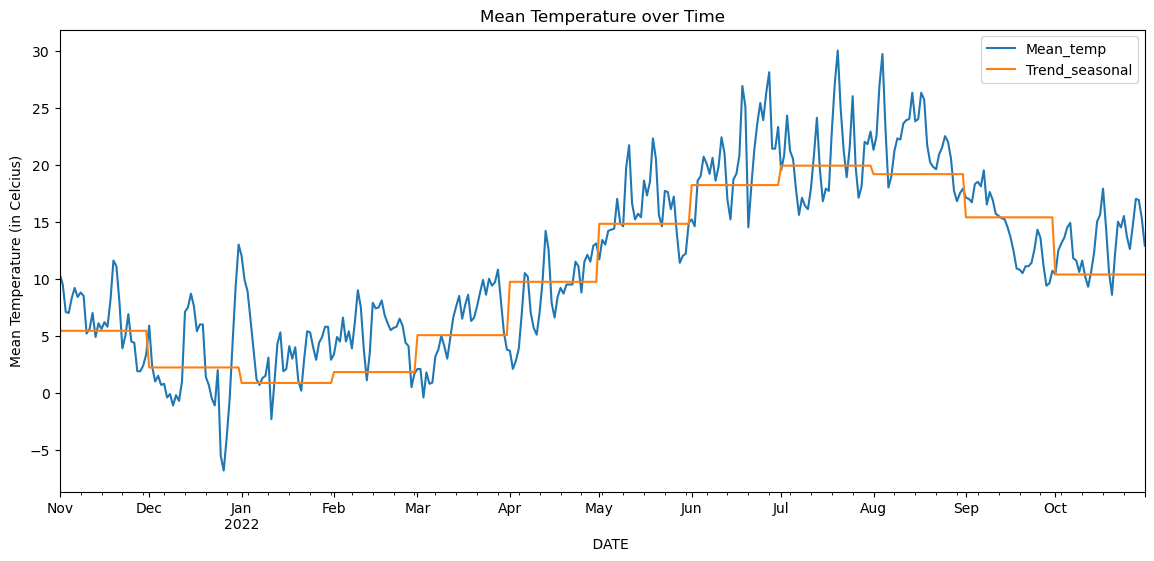

In [88]:
plot_temp(df_test[["Mean_temp", 'Trend_seasonal']], ylim=False)

In [89]:
df_test['Remainder'] = df_test['Mean_temp'] - df_test['Trend_seasonal']

/tmp/ipykernel_64762/2705029176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Remainder'] = df_test['Mean_temp'] - df_test['Trend_seasonal']


In [90]:
df_test['lag1'] = df_test['Remainder'].shift(1)
df_test['lag2'] = df_test['Remainder'].shift(2)
df_test['lag3'] = df_test['Remainder'].shift(3)
df_test['lag4'] = df_test['Remainder'].shift(4)
df_test['lag5'] = df_test['Remainder'].shift(5)

/tmp/ipykernel_64762/1810448025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lag1'] = df_test['Remainder'].shift(1)
/tmp/ipykernel_64762/1810448025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lag2'] = df_test['Remainder'].shift(2)
/tmp/ipykernel_64762/1810448025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [91]:
df_test.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_10,month_11,month_12,Trend_seasonal,Remainder,lag1,lag2,lag3,lag4,lag5
DATE,,,,,,,,,,,,,,,,,,,,,
2021-11-01,10.4,11,2021,53265,0,0,0,0,0,0,...,0,1,0,5.441248,4.958752,NaN,NaN,NaN,NaN,NaN
2021-11-02,9.5,11,2021,53266,0,0,0,0,0,0,...,0,1,0,5.441281,4.058719,4.958752,NaN,NaN,NaN,NaN
2021-11-03,7.1,11,2021,53267,0,0,0,0,0,0,...,0,1,0,5.441314,1.658686,4.058719,4.958752,NaN,NaN,NaN
2021-11-04,7.0,11,2021,53268,0,0,0,0,0,0,...,0,1,0,5.441347,1.558653,1.658686,4.058719,4.958752,NaN,NaN
2021-11-05,8.3,11,2021,53269,0,0,0,0,0,0,...,0,1,0,5.441379,2.858621,1.558653,1.658686,4.058719,4.958752,NaN


Filling in the missing value from the beginning of the test lag.

In [92]:
df_test["lag1"] = df_test["lag1"].fillna(method="bfill")
df_test["lag2"] = df_test["lag2"].fillna(method="bfill")
df_test["lag3"] = df_test["lag3"].fillna(method="bfill")
df_test["lag4"] = df_test["lag4"].fillna(method="bfill")
df_test["lag5"] = df_test["lag5"].fillna(method="bfill")

/tmp/ipykernel_64762/1245516116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["lag1"] = df_test["lag1"].fillna(method="bfill")
/tmp/ipykernel_64762/1245516116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["lag2"] = df_test["lag2"].fillna(method="bfill")
/tmp/ipykernel_64762/1245516116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [93]:
df_test.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_10,month_11,month_12,Trend_seasonal,Remainder,lag1,lag2,lag3,lag4,lag5
DATE,,,,,,,,,,,,,,,,,,,,,
2021-11-01,10.4,11,2021,53265,0,0,0,0,0,0,...,0,1,0,5.441248,4.958752,4.958752,4.958752,4.958752,4.958752,4.958752
2021-11-02,9.5,11,2021,53266,0,0,0,0,0,0,...,0,1,0,5.441281,4.058719,4.958752,4.958752,4.958752,4.958752,4.958752
2021-11-03,7.1,11,2021,53267,0,0,0,0,0,0,...,0,1,0,5.441314,1.658686,4.058719,4.958752,4.958752,4.958752,4.958752
2021-11-04,7.0,11,2021,53268,0,0,0,0,0,0,...,0,1,0,5.441347,1.558653,1.658686,4.058719,4.958752,4.958752,4.958752
2021-11-05,8.3,11,2021,53269,0,0,0,0,0,0,...,0,1,0,5.441379,2.858621,1.558653,1.658686,4.058719,4.958752,4.958752


In [94]:
# Assign X_full
X_full = df_test.drop(columns=["Mean_temp", "Month", "Year", "Trend_seasonal", "Remainder"])

In [95]:
X_full.head()

,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
DATE,,,,,,,,,,,,,,,,,
2021-11-01,53265,0,0,0,0,0,0,0,0,0,1,0,4.958752,4.958752,4.958752,4.958752,4.958752
2021-11-02,53266,0,0,0,0,0,0,0,0,0,1,0,4.958752,4.958752,4.958752,4.958752,4.958752
2021-11-03,53267,0,0,0,0,0,0,0,0,0,1,0,4.058719,4.958752,4.958752,4.958752,4.958752
2021-11-04,53268,0,0,0,0,0,0,0,0,0,1,0,1.658686,4.058719,4.958752,4.958752,4.958752
2021-11-05,53269,0,0,0,0,0,0,0,0,0,1,0,1.558653,1.658686,4.058719,4.958752,4.958752


In [96]:
df_test["predictions_full_model"] = m_full.predict(X_full)

/tmp/ipykernel_64762/3645684801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["predictions_full_model"] = m_full.predict(X_full)


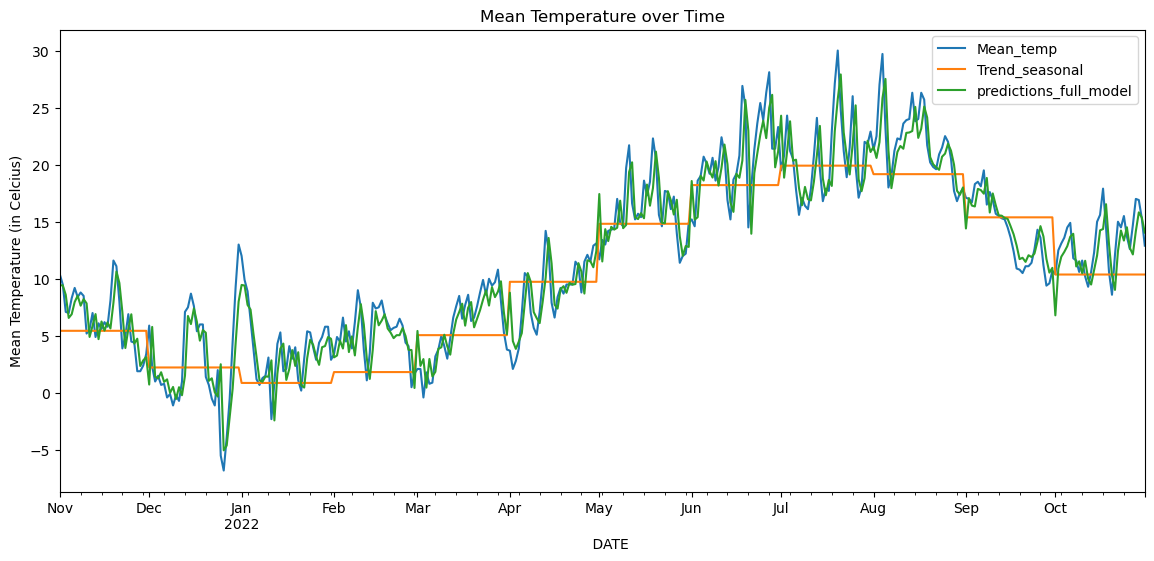

In [97]:
plot_temp(df_test[["Mean_temp", "Trend_seasonal", "predictions_full_model"]], ylim = False)

In [98]:
df_test.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,Trend_seasonal,Remainder,lag1,lag2,lag3,lag4,lag5,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
2021-11-01,10.4,11,2021,53265,0,0,0,0,0,0,...,1,0,5.441248,4.958752,4.958752,4.958752,4.958752,4.958752,4.958752,9.427125
2021-11-02,9.5,11,2021,53266,0,0,0,0,0,0,...,1,0,5.441281,4.058719,4.958752,4.958752,4.958752,4.958752,4.958752,9.427157
2021-11-03,7.1,11,2021,53267,0,0,0,0,0,0,...,1,0,5.441314,1.658686,4.058719,4.958752,4.958752,4.958752,4.958752,8.600273
2021-11-04,7.0,11,2021,53268,0,0,0,0,0,0,...,1,0,5.441347,1.558653,1.658686,4.058719,4.958752,4.958752,4.958752,6.569880
2021-11-05,8.3,11,2021,53269,0,0,0,0,0,0,...,1,0,5.441379,2.858621,1.558653,1.658686,4.058719,4.958752,4.958752,6.892535


In [99]:
df_train.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,Trend_seasonal,Remainder,lag1,lag2,lag3,lag4,lag5,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,1,1876,0,0,0,0,0,0,0,...,0,0,-0.874636,3.074636,3.074636,3.074636,3.074636,3.074636,3.074636,1.610553
1876-01-02,2.5,1,1876,1,0,0,0,0,0,0,...,0,0,-0.874603,3.374603,3.074636,3.074636,3.074636,3.074636,3.074636,1.610586
1876-01-03,0.3,1,1876,2,0,0,0,0,0,0,...,0,0,-0.874570,1.174570,3.374603,3.074636,3.074636,3.074636,3.074636,1.886217
1876-01-04,-5.8,1,1876,3,0,0,0,0,0,0,...,0,0,-0.874538,-4.925462,1.174570,3.374603,3.074636,3.074636,3.074636,-0.193262
1876-01-05,-9.8,1,1876,4,0,0,0,0,0,0,...,0,0,-0.874505,-8.925495,-4.925462,1.174570,3.374603,3.074636,3.074636,-5.353786


In [100]:
df_full = df_train[["Mean_temp", "Trend_seasonal", "predictions_full_model"]].append(df_test[["Mean_temp", "Trend_seasonal", "predictions_full_model"]])

/tmp/ipykernel_64762/3391069552.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_train[["Mean_temp", "Trend_seasonal", "predictions_full_model"]].append(df_test[["Mean_temp", "Trend_seasonal", "predictions_full_model"]])


In [101]:
df_full.head()

,Mean_temp,Trend_seasonal,predictions_full_model
DATE,,,
1876-01-01,2.2,-0.874636,1.610553
1876-01-02,2.5,-0.874603,1.610586
1876-01-03,0.3,-0.874570,1.886217
1876-01-04,-5.8,-0.874538,-0.193262
1876-01-05,-9.8,-0.874505,-5.353786


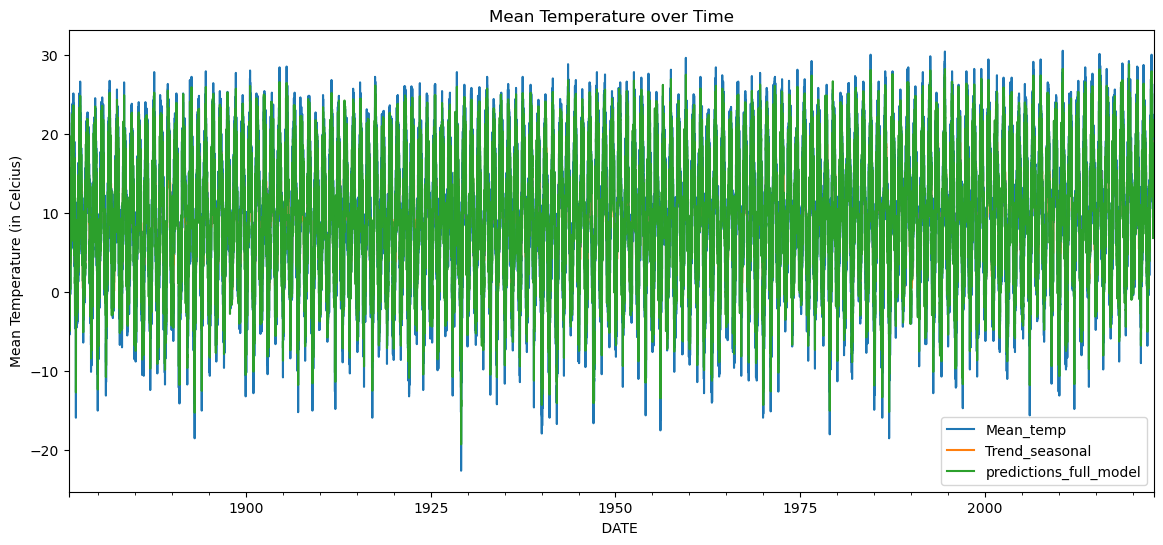

In [102]:
plot_temp(df_full, ylim = False)

In [103]:
print(f"""
full model = {m_full.score(X_full, df_test["Mean_temp"])}
trend_seasonal = {m.score(X_test, df_test["Mean_temp"])}
""")



full model = 0.9170272697505631
trend_seasonal = 0.758760431880951



# 8. Predict

In [104]:
df_test.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,Trend_seasonal,Remainder,lag1,lag2,lag3,lag4,lag5,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
2021-11-01,10.4,11,2021,53265,0,0,0,0,0,0,...,1,0,5.441248,4.958752,4.958752,4.958752,4.958752,4.958752,4.958752,9.427125
2021-11-02,9.5,11,2021,53266,0,0,0,0,0,0,...,1,0,5.441281,4.058719,4.958752,4.958752,4.958752,4.958752,4.958752,9.427157
2021-11-03,7.1,11,2021,53267,0,0,0,0,0,0,...,1,0,5.441314,1.658686,4.058719,4.958752,4.958752,4.958752,4.958752,8.600273
2021-11-04,7.0,11,2021,53268,0,0,0,0,0,0,...,1,0,5.441347,1.558653,1.658686,4.058719,4.958752,4.958752,4.958752,6.569880
2021-11-05,8.3,11,2021,53269,0,0,0,0,0,0,...,1,0,5.441379,2.858621,1.558653,1.658686,4.058719,4.958752,4.958752,6.892535


In [105]:
df_combined = df_train.append(df_test)

/tmp/ipykernel_64762/2541881474.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_train.append(df_test)


In [106]:
df_combined.head()

,Mean_temp,Month,Year,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,Trend_seasonal,Remainder,lag1,lag2,lag3,lag4,lag5,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,1,1876,0,0,0,0,0,0,0,...,0,0,-0.874636,3.074636,3.074636,3.074636,3.074636,3.074636,3.074636,1.610553
1876-01-02,2.5,1,1876,1,0,0,0,0,0,0,...,0,0,-0.874603,3.374603,3.074636,3.074636,3.074636,3.074636,3.074636,1.610586
1876-01-03,0.3,1,1876,2,0,0,0,0,0,0,...,0,0,-0.874570,1.174570,3.374603,3.074636,3.074636,3.074636,3.074636,1.886217
1876-01-04,-5.8,1,1876,3,0,0,0,0,0,0,...,0,0,-0.874538,-4.925462,1.174570,3.374603,3.074636,3.074636,3.074636,-0.193262
1876-01-05,-9.8,1,1876,4,0,0,0,0,0,0,...,0,0,-0.874505,-8.925495,-4.925462,1.174570,3.374603,3.074636,3.074636,-5.353786


Retrain the model on the whole dataset

In [107]:
X_combined = df_combined.drop(columns = ["Mean_temp", "Month", "Year", "Trend_seasonal", "Remainder", "predictions_full_model"])
y_combined = df_combined["Mean_temp"]

In [108]:
X_combined.tail(1)

,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
DATE,,,,,,,,,,,,,,,,,
2022-10-31,53629,0,0,0,0,0,0,0,0,1,0,0,4.926498,6.526531,6.626564,4.326596,2.226629


In [109]:
m_combined = LinearRegression()

In [110]:
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [111]:
m_combined.coef_

array([ 3.29969800e-05,  9.62045729e-01,  4.18739216e+00,  8.82618629e+00,
        1.39086327e+01,  1.72671604e+01,  1.89885442e+01,  1.82083740e+01,
        1.44568464e+01,  9.45232143e+00,  4.56092498e+00,  1.34880875e+00,
        9.19297758e-01, -1.95108717e-01,  5.75228759e-02,  3.78223929e-03,
        1.39754195e-02])

Create a single future step data point.

In [112]:
timestep = df_combined["Timestep"].max() + 1
months = [0]*9 + [1] + [0]
lag1 = df_combined.loc["2022-10-01", "lag1"]
lag2 = df_combined.loc["2022-10-01", "lag2"]
lag3 = df_combined.loc["2022-10-01", "lag3"]
lag4 = df_combined.loc["2022-10-01", "lag4"]
lag5 = df_combined.loc["2022-10-01", "lag5"]

In [113]:
timestep, months, lag1, lag2, lag3, lag4, lag5

(53630,
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 -4.684198194450833,
 -5.784165412630246,
 -5.984132630809656,
 -4.184099848989071,
 -1.7840670671684844)

In [114]:
X_future = []
X_future.append(timestep)
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
X_future.append(lag4)
X_future.append(lag5)
X_future = pd.DataFrame([X_future])

In [115]:
X_combined.head(1)

,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
DATE,,,,,,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0,0,3.074636,3.074636,3.074636,3.074636,3.074636


In [116]:
X_future

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,53630,0,0,0,0,0,0,0,0,0,1,0,-4.684198,-5.784165,-5.984133,-4.1841,-1.784067


In [118]:
X_future.columns = X_combined.columns

In [119]:
X_future

,Timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
0,53630,0,0,0,0,0,0,0,0,0,1,0,-4.684198,-5.784165,-5.984133,-4.1841,-1.784067


Predict for 2022-11-01.

In [120]:
m_full.predict(X_future)

array([1.91046779])

In [117]:
m_combined.predict(X_future)

/home/nteni/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([1.91748801])